In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier


In [ ]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
np.random.seed(42)

In [ ]:
def add_noise(df, noise_level=0.25):
    noisy_df = df.copy()
    for column in df.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_level * df[column].std(), df[column].shape)
        noisy_df[column] += noise
    return noisy_df

In [ ]:
folder_path = "/content/drive/MyDrive/Features ASD_TD/"

# Initialize an empty list to store the combined data and labels
data_list = []
labels = []
# Iterate through the ASD and TD folders
for label, folder_name in enumerate(["ASD", "TD"]):
    folder_dir = os.path.join(folder_path, folder_name)

    # Iterate through files in each folder
    for file_name in os.listdir(folder_dir):
        if file_name.endswith(".xlsx"):
            file_path = os.path.join(folder_dir, file_name)
            # Check if the corresponding bands file exists
            bands_file_path = os.path.join(folder_dir, file_name.split('.')[0] + "_bands.xlsx")
            if os.path.exists(bands_file_path):
                # Read both excel files
                df_main = pd.read_excel(file_path)
                df_bands = pd.read_excel(bands_file_path)
                # Combine along columns
                combined_df = pd.concat([df_main, df_bands], axis=1)
                combined_df = add_noise(combined_df)
                # Append the combined data and label to the list
                data_list.append(combined_df)
                labels.append(label)



In [ ]:
labels = np.array(labels)

In [ ]:
data_list = np.array(data_list)

In [ ]:
""" Data Augmentation"""

def augment_data(data, labels, target_samples=1000, noise_factor=0.5):
    augmented_data = []
    augmented_labels = []

    while len(augmented_data) < target_samples:
        idx = np.random.randint(0, len(data))
        original_sample = data[idx]
        original_label = labels[idx]

        noisy_sample = original_sample + noise_factor * np.random.normal(size=original_sample.shape)

        augmented_data.append(noisy_sample)
        augmented_labels.append(original_label)

    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    return augmented_data, augmented_labels

augmented_data, augmented_labels = augment_data(data_list, labels, target_samples=1000, noise_factor=5)

In [ ]:
from sklearn.preprocessing import StandardScaler

data_2d = np.asarray(data_list).reshape(-1, np.asarray(data_list).shape[-1])

scaler = StandardScaler()
scaled_data_2d = scaler.fit_transform(data_2d)
data = scaled_data_2d.reshape(np.asarray(data_list).shape)

In [ ]:
""" XGB_GB Classifier """

# Initialize the individual classifiers
xgb_classifier = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8
)

gb_classifier = GradientBoostingClassifier()

# Combine the classifiers using a voting classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('xgb', xgb_classifier),
        ('gb', gb_classifier)
    ],
    voting='soft'
)

Mean Accuracy: 0.72


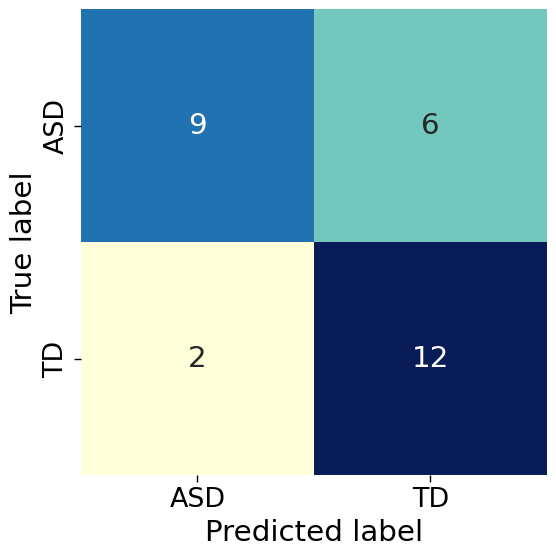

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
all_y_true = []
all_y_pred = []

# Perform K-Fold CV
for train_index, test_index in kf.split(data):

    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    xgb_classifier.fit(X_train, y_train)
    gb_classifier.fit(X_train, y_train)


    # Fit the model
    voting_classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = voting_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(accuracy)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

mean_accuracy = np.mean(accuracies)

print(f"Mean Accuracy: {mean_accuracy:.2f}")

conf_matrix = confusion_matrix(all_y_true, all_y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['TD', 'ASD'], columns=['TD', 'ASD'])

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 6))
sns.set_context('paper', font_scale=2.2)
sns.heatmap(conf_matrix_df, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=['ASD', 'TD'],
            yticklabels=['ASD', 'TD'],
            cbar=False)  # Remove the color bar
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('conf_XGB_GB.eps', format='eps')
plt.show()

In [ ]:
print('Mean of Accuracies is: ', np.mean(accuracies))
print('SD of Accuracies is: ', np.std(accuracies))

Mean of Accuracies is:  0.72
SD of Accuracies is:  0.09568466729604885


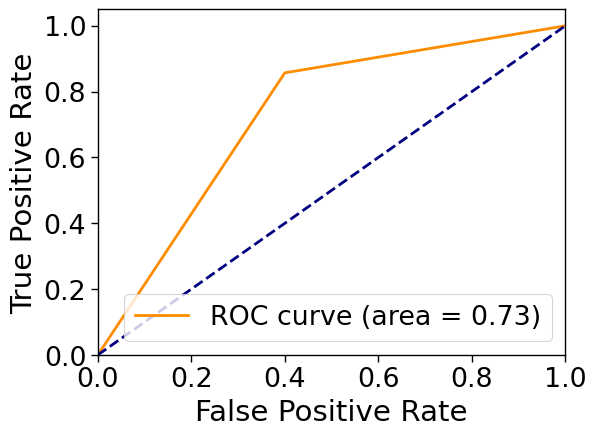

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_y_true, all_y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve_XGB_GB.eps', format='eps')
plt.show()

In [ ]:
""" Time Domain Features """

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
all_y_true = []
all_y_pred = []

# Perform K-Fold CV
for train_index, test_index in kf.split(data):

    X_train, X_test = data[train_index, 0:6], data[test_index, 0:6]
    y_train, y_test = labels[train_index], labels[test_index]

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    xgb_classifier.fit(X_train, y_train)
    gb_classifier.fit(X_train, y_train)


    # Fit the model
    voting_classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = voting_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(accuracy)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

mean_accuracy = np.mean(accuracies)

print(f"Mean Accuracy: {mean_accuracy:.2f}")

conf_matrix = confusion_matrix(all_y_true, all_y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['TD', 'ASD'], columns=['TD', 'ASD'])

print('Mean of Accuracies for Time Domain is: ', np.mean(accuracies))
print('SD of Accuracies for Frequency Domain is: ', np.std(accuracies))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Mean Accuracy: 0.90
Mean of Accuracies for Time Domain is:  0.9
SD of Accuracies for Frequency Domain is:  0.1527525231651947


In [ ]:
""" Frequency Domain Features """


kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
all_y_true = []
all_y_pred = []

# Perform K-Fold CV
for train_index, test_index in kf.split(data):

    X_train, X_test = data[train_index, 6:], data[test_index, 6:]
    y_train, y_test = labels[train_index], labels[test_index]

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    xgb_classifier.fit(X_train, y_train)
    gb_classifier.fit(X_train, y_train)


    # Fit the model
    voting_classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = voting_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(accuracy)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

mean_accuracy = np.mean(accuracies)

print(f"Mean Accuracy: {mean_accuracy:.2f}")

conf_matrix = confusion_matrix(all_y_true, all_y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['TD', 'ASD'], columns=['TD', 'ASD'])

print('Mean of Accuracies for Time Domain is: ', np.mean(accuracies))
print('SD of Accuracies for Frequency Domain is: ', np.std(accuracies))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean Accuracy: 0.55
Mean of Accuracies for Time Domain is:  0.5499999999999999
SD of Accuracies for Frequency Domain is:  0.3655285366576885


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
